# Outfit classification

# Training

In [1]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision.models.vision_transformer import VisionTransformer
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

random.seed(42)

In [2]:
IMAGE_SIZE = 448

transform = Compose([
    Resize([IMAGE_SIZE, IMAGE_SIZE]),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the datasets using ImageFolder
dataset = ImageFolder(
    root="../complete-the-look-dataset/outfit-classification/train",
    transform=transform,
)

train_idx, valid_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42,
                                        shuffle=True, stratify=dataset.targets)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, valid_idx)

model = VisionTransformer(image_size=IMAGE_SIZE, patch_size=16, num_layers=4, 
                          num_heads=8, hidden_dim=64, mlp_dim=64, 
                          dropout=0.25, attention_dropout=0.1, num_classes=len(dataset.classes))

for param in model.parameters():
    param.requires_grad = False

in_features = model.heads.head.in_features
model.heads = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128, len(dataset.classes))
)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps"

# Move model to the device
model.to(device)

In [3]:
# Define batch size
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Initialize the ViT model
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Define the loss function
criterion = nn.BCELoss()

In [5]:
best_val_loss = float('inf')  # Initialize with a very large value
best_checkpoint_path = None
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        labels = labels.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(train_loss)

    model.eval()
    epoch_val_losses = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float()
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

        val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        val_losses.append(val_loss)

        # Save the model checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            best_checkpoint_path = os.path.join("../checkpoints/outfit-classification-vit", 
                                                f'best_model_{current_datetime}_epoch_{epoch + 1}.pt')
            torch.save(model.state_dict(), best_checkpoint_path)
            print(f"Best checkpoint saved for epoch {epoch + 1} at {best_checkpoint_path}")

    print(f"Epoch {epoch + 1}, train loss = {train_loss:.2f}, val_loss = {val_loss:.2f}")

Best checkpoint saved for epoch 1 at ../checkpoints/outfit-classification-vit/best_model_2024-03-26_21-48-04_epoch_1.pt
Epoch 1, train loss = 0.6938717045954296, val_loss = 0.6931779540793972
Epoch 2, train loss = 0.6934438234872062, val_loss = 0.693330370303351
Epoch 3, train loss = 0.6933600115255459, val_loss = 0.6933390190211338
Epoch 4, train loss = 0.6933103736950502, val_loss = 0.6932228184646364
Epoch 5, train loss = 0.6932614962980537, val_loss = 0.6931815379906547
Best checkpoint saved for epoch 6 at ../checkpoints/outfit-classification-vit/best_model_2024-03-26_23-51-48_epoch_6.pt
Epoch 6, train loss = 0.6932417313029906, val_loss = 0.6931550570279029
Best checkpoint saved for epoch 7 at ../checkpoints/outfit-classification-vit/best_model_2024-03-27_00-15-58_epoch_7.pt
Epoch 7, train loss = 0.6932076543878397, val_loss = 0.6931440532428084
Epoch 8, train loss = 0.6932008352149953, val_loss = 0.693179060096303
Epoch 9, train loss = 0.6932333443868081, val_loss = 0.69315315815

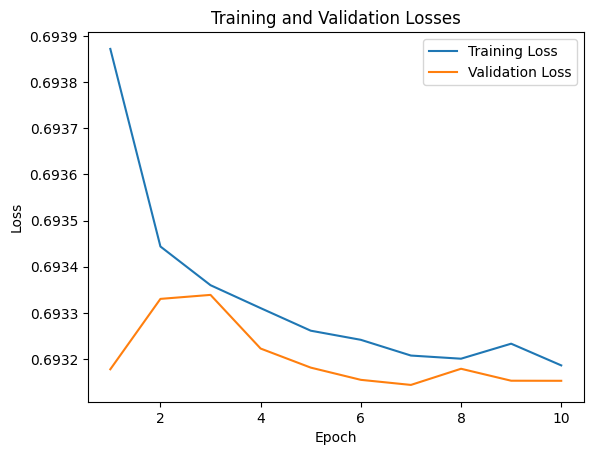

In [6]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Test Accuracy: 0.5000497166152928
Test AUC: 0.5001318525978126


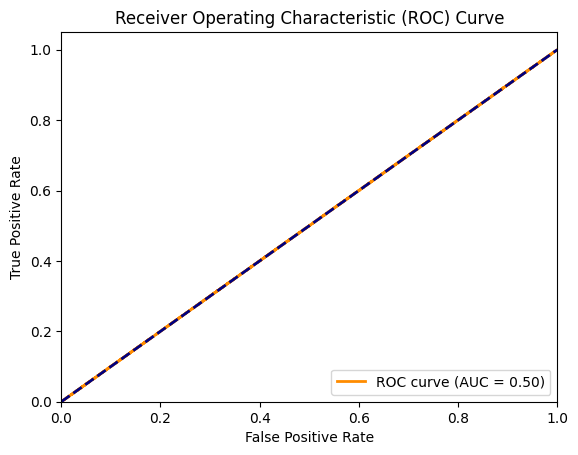

In [7]:
test_dataset = ImageFolder(
    root="../complete-the-look-dataset/outfit-classification/test",
    transform=transform,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Lists to store true labels and predicted scores
true_labels = []
predicted_scores = []

# Load the best checkpoint
model.load_state_dict(torch.load(best_checkpoint_path))
model.to(device)

# Iterate over the test set and collect true labels and predicted scores
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        labels = labels.unsqueeze(1)
        outputs = model(images)
        predicted_scores.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

# Calculate test accuracy
predicted_labels = np.round(predicted_scores)
test_accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy:", test_accuracy)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print("Test AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Evaluation

In [8]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision.models.vision_transformer import VisionTransformer
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from concurrent.futures import ThreadPoolExecutor

random.seed(42)

In [11]:
IMAGE_SIZE = 224

transform = Compose([
    Resize([IMAGE_SIZE, IMAGE_SIZE]),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

model = VisionTransformer(image_size=IMAGE_SIZE, patch_size=16, num_layers=4, 
                          num_heads=8, hidden_dim=64, mlp_dim=64, 
                          dropout=0.25, attention_dropout=0.1, num_classes=len(dataset.classes))

for param in model.parameters():
    param.requires_grad = False

in_features = model.heads.head.in_features
model.heads = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128, len(dataset.classes))
)

best_checkpoint_path = "../checkpoints/outfit-classification-vit/best_model_2024-03-27_00-15-58_epoch_7.pt"
model.load_state_dict(torch.load(best_checkpoint_path))
device = "mps"
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 64, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.25, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (dropout): Dropout(p=0.25, inplace=False)
        (ln_2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.25, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0.25, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (self_attention

In [12]:
def concatenate_images(images):
    # Find the dimensions of the largest image
    max_width = max(image.width for image in images)
    max_height = max(image.height for image in images)

    # Resize each image to the dimensions of the largest image
    resized_images = [image.resize((max_width, max_height)) for image in images]

    # Concatenate the resized images
    total_width = sum(image.width for image in resized_images)
    concatenated_image = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for image in resized_images:
        concatenated_image.paste(image, (x_offset, 0))
        x_offset += image.width

    return concatenated_image

In [13]:
test_items_df = pd.read_csv("../complete-the-look-dataset/datasets/preprocessed/test.csv")
test_items_df['image_path'] = "../complete-the-look-dataset/items/test/" + test_items_df['label'] + '/' +\
    test_items_df['image_signature'] + '.jpg'

# Gather all image_path with the same image_signature as a dictionary
image_paths_grouped = test_items_df.groupby('image_signature')['image_path'].apply(list).to_dict()
image_paths_dict = {k: v for k, v in image_paths_grouped.items() if len(v) > 1}

correct = 0

start_time = time.time()
# Loop over the dictionary
for image_signature, image_paths in image_paths_dict.items():
    # Remove an item in the image_paths randomly
    multi_choice_paths = []
    removed_path = image_paths.pop(np.random.randint(0, len(image_paths)))
    # Check the label of removed_path
    label = test_items_df.loc[test_items_df['image_path'] == removed_path, 'label'].values[0]
    
    for _ in range(3):
        # Choose an image with the same label as removed_path label
        label_df = test_items_df[test_items_df['label'] == label]
        chosen_path = label_df.iloc[np.random.randint(0, len(label_df)), 2]
        multi_choice_paths.append(chosen_path)
    multi_choice_paths.append(removed_path)
    outfit_compability_scores = []
    
    # Concat all images in multi_choice_paths using PIL
    for path in multi_choice_paths:
        new_combo = []
        
        new_combo = [image_path for image_path in image_paths]
        images = [Image.open(path) for path in new_combo]
        concatenated_image = concatenate_images(images)
        input = transform(concatenated_image)
        # Use model to output the score
        with torch.no_grad():
            outputs = model(input.unsqueeze(0).to(device))
            outfit_compability_scores.append(outputs.cpu().numpy())
            
    # Get the index of the item has best score
    best_score_index = np.argmax(outfit_compability_scores)
    # Check if best_score_index equals the index of removed_path
    if best_score_index == len(multi_choice_paths) - 1:
        correct += 1

end_time = time.time()

In [14]:
fitb_acc = correct / len(image_paths_dict) * 100
print(f"Fill in the blank accuracy: {fitb_acc:.2f}%")
avg_eval_time = (end_time - start_time) / len(image_paths_dict)
print(f"Average evaluation time for each combination: {avg_eval_time:.2f}s")

Fill in the blank accuracy: 24.11%
Average evaluation time for each combination: 0.06s
